In [79]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy

In [3]:
%load_ext PWE_NB_Extension

In [93]:
%%dlv --donot-run --donot-display_input -lci edb_instance

% Graph Instance
% graphviz graph graph_type=directed rankdir=LR

% Defining the edges
% schema e(tail, head)
% graphviz edge e(HEAD,TAIL) ord=2 style=solid
% e(a,b). e(b,c). e(c,b). e(c,d).

e(a,b). e(a,c).
e(b,d). e(b,e).
e(c,d). e(c,e).
e(d,f). e(e,f).
e(a,h). e(e,h).

n(b). n(c). n(d). n(e). n(h).

n(X) :- e(X,_).
n(X) :- e(_,X).

In [94]:
%%dlv --donot-run --donot-display_input -lci tc_rules

% Standard Transitive Closure Rules
% schema tc(tail, head)
% graphviz edge tc(HEAD, TAIL) ord=1 style=dashed

% tc(X,Y) :- e(X,Y).          % r1
% tc(X,Y) :- e(X,Z), tc(Z,Y). % r2

% q(X,Y) :- tc(a,f).



e(X,Y) :- i(X,Y).
    
tc4(X,Y, X,Y) :- e(X,Y).

tc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY).
tc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).

% Again, let's see who is on paths from a to f: 
q(IX,IY) :- tc4(a,f,IX,IY).

In [95]:
%%clingo -l tc_rules edb_instance --donot-display_input --save_meta_data_to std_md --saveto std_inst_out
#show tc/2.
#show e/2.
#show q/2.

Output:


''

In [69]:
dd_pw_rel_dfs, dd_schemas, dd_pw_objs = load_worlds(std_inst_out, std_md, print_parse_tree=False, reasoner='clingo')

Number of Models: 1


In [70]:
dd_pw_rel_dfs.keys()

dict_keys(['e_2', 'q_2'])

In [71]:
dd_pw_rel_dfs['q_2']

,pw,x1,x2
0,1,d,f
1,1,e,f
2,1,c,e
3,1,b,e
4,1,c,d
5,1,b,d
6,1,a,b
7,1,a,c


In [72]:
std_md

{'temporal_dec': {},
 'attr_def': {'tc_2': ['tail', 'head'], 'e_2': ['tail', 'head']},
 'graphviz': {'graph': {'styles': [('graph_type', 'direct', 'directed'),
    ('rankdir', 'direct', 'LR')],
   'graph_type': 'directed'},
  'node': {},
  'edge': {'tc_2': {'head': 0,
    'tail': 1,
    'styles': [('ord', 'direct', 1), ('style', 'direct', 'dashed')],
    'ord': 1},
   'e_2': {'head': 0,
    'tail': 1,
    'styles': [('ord', 'direct', 2), ('style', 'direct', 'solid')],
    'ord': 2}}}}

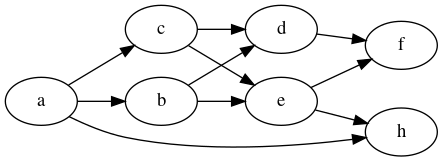

In [73]:
g = PWEVisualization.graphviz_from_meta_data(dd_pw_rel_dfs, std_md['graphviz'])
draw(g)

In [82]:
shortest_path = list(nx.shortest_path(g, 'a', 'f'))
print(' --> '.join(shortest_path))

a --> b --> d --> f


In [91]:
shortest_paths = list(nx.all_simple_paths(g, 'a', 'f'))
shortest_paths

[['a', 'b', 'd', 'f'],
 ['a', 'b', 'e', 'f'],
 ['a', 'c', 'd', 'f'],
 ['a', 'c', 'e', 'f']]

In [89]:
shortest_path = list(nx.all_shortest_paths(g, 'a', 'f'))


[['a', 'b', 'd', 'f'],
 ['a', 'c', 'd', 'f'],
 ['a', 'b', 'e', 'f'],
 ['a', 'c', 'e', 'f']]

In [83]:
shortest_path_edges = list(zip(shortest_path, shortest_path[1:]))

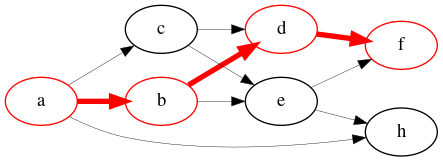

In [84]:
G_temp = deepcopy(g)
for node in shortest_path:
    G_temp.nodes[node]['color'] = 'red'
for edge in G_temp.edges:
    G_temp.edges[edge]['penwidth'] = 0.3
for edge in shortest_path_edges:
    G_temp.edges[edge]['color'] = 'red'
    G_temp.edges[edge]['penwidth'] = 4
draw(G_temp)

In [39]:
%%clingo --run



e(a,b). 
e(a,c).

e(d,f).
e(e,f).


n(X) :- e(X,_).
n(X) :- e(_,X).

e(X,Y) :- n(X), n(Y)
% i(X,Y) v o(X,Y) :- n(X), n(Y), X!=Y.

% n(b). n(c). n(d). n(e).

% e(X,Y) :- n(X), n(Y), X!=Y
% :- e(X,Y), e(Y,X)
    
% tc4(X,Y, X,Y) :- e(X,Y).

% tc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY).
% tc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).

% % Again, let's see who is on paths from a to f: 
% q(IX,IY) :- tc4(a,f,IX,IY).

Input:


"e(a,b).\ne(a,c).\n\ne(d,f).\ne(e,f).\n\n\nn(X) :- e(X,_).\nn(X) :- e(_,X).\n\ne(X,Y) :- n(X), n(Y)\n% i(X,Y) v o(X,Y) :- n(X), n(Y), X!=Y.\n\n% n(b). n(c). n(d). n(e).\n\n% e(X,Y) :- n(X), n(Y), X!=Y\n% :- e(X,Y), e(Y,X)\n\n% tc4(X,Y, X,Y) :- e(X,Y).\n\n% tc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY).\n% tc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).\n\n% % Again, let's see who is on paths from a to f:\n% q(IX,IY) :- tc4(a,f,IX,IY)."

Output:


'clingo version 5.4.0\nReading from ...hcysbfhcbygweincbsydgibwyebcsygdyc.lp4\nUNKNOWN\n\nModels       : 0+\nCalls        : 1\nTime         : 0.000s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.000s'

In [24]:
%%clingo --run

n(b). n(c). n(d). n(e).

e(a,b). 
e(a,c).

e(d,f).
e(e,f).

e(X,Y) :- n(X), n(Y), X!=Y
:- e(X,Y), e(Y,X)
    
tc4(X,Y, X,Y) :- e(X,Y).

tc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY).
tc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).

% Again, let's see who is on paths from a to f: 
q(IX,IY) :- tc4(a,f,IX,IY).

Input:


'n(b). n(c). n(d). n(e).\n\ne(a,b).\ne(a,c).\n\ne(d,f).\ne(e,f).\n\ne(X,Y) :- n(X), n(Y), X!=Y\n:- e(X,Y), e(Y,X)'

Output:


'clingo version 5.4.0\nReading from ...hcysbfhcbygweincbsydgibwyebcsygdyc.lp4\nUNKNOWN\n\nModels       : 0+\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.000s'

In [23]:
%%clingo --run

n(a). n(b). n(c). n(d). n(e). n(f).

e(a,b). 
e(a,c).

e(d,f).
e(e,f).

%n(X) :- e(X,_)
%n(X) :- e(_,X)

i(X,Y) v o(X,Y) :- n(X), n(Y), X!=Y
:- i(X,Y), i(Y,X)
    
e(X,Y) :- i(X,Y).

tc4(X,Y, X,Y) :- e(X,Y).

tc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY).
tc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).

% Again, let's see who is on paths from a to f: 
q(IX,IY) :- tc4(a,f,IX,IY).


Input:


"n(a). n(b). n(c). n(d). n(e). n(f).\n\ne(a,b).\ne(a,c).\n\ne(d,f).\ne(e,f).\n\n%n(X) :- e(X,_)\n%n(X) :- e(_,X)\n\ni(X,Y) v o(X,Y) :- n(X), n(Y), X!=Y\n:- i(X,Y), i(Y,X)\n\ne(X,Y) :- i(X,Y).\n\ntc4(X,Y, X,Y) :- e(X,Y).\n\ntc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY).\ntc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).\n\n% Again, let's see who is on paths from a to f:\nq(IX,IY) :- tc4(a,f,IX,IY)."

Output:


'clingo version 5.4.0\nReading from ...hcysbfhcbygweincbsydgibwyebcsygdyc.lp4\nUNKNOWN\n\nModels       : 0+\nCalls        : 1\nTime         : 0.000s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.000s'

In [8]:
simpleRules = ['e(a,b). e(a,c).',
'e(b,d). e(b,e).',
'e(c,d). e(c,e).',
'e(d,f). e(e,f).']

In [9]:
%clingo -l simpleRules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

Output:


'Answer: 1\ne(a,b) e(a,c) e(b,d) e(b,e) e(c,d) e(c,e) e(d,f) e(e,f)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.000s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.000s'

In [10]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 1


In [11]:
pw_rels_dfs.keys()

dict_keys(['e_2'])

In [ ]:
edge_rel_name = 'e_{}'.format(2*NUM_DISKS)


In [18]:
pw_rels_dfs['e_2']

,pw,x1,x2
0,1,a,b
1,1,a,c
2,1,b,d
3,1,b,e
4,1,c,d
5,1,c,e
6,1,d,f
7,1,e,f
